<a href="https://colab.research.google.com/github/als1379/Statistical-and-Mathematical-Methods-for-Artificial-Intelligence/blob/main/HW2/HW2_Clustering_with_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("animatronbot/mnist-digit-recognizer")

print("Path to dataset files:", path)

100%|██████████| 9.16M/9.16M [00:00<00:00, 11.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/animatronbot/mnist-digit-recognizer/versions/1


In [ ]:
import pandas as pd
import numpy as np

dataset = pd.read_csv(path + '/train.csv')

In [ ]:
y = dataset['label']
X = dataset.drop('label', axis=1)

# Assuming X is already defined as a NumPy array (if not, convert it using X = np.array(X))
X_filtered = X[(y == 0) | (y == 6) | (y == 9)]
y_filtered = y[(y == 0) | (y == 6) | (y == 9)]

print("Shape of X_filtered:", X_filtered.shape)
print("Shape of y_filtered:", y_filtered.shape)

Shape of X_filtered: (12457, 784)
Shape of y_filtered: (12457,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (9965, 784)
Shape of y_train: (9965,)
Shape of X_test: (2492, 784)
Shape of y_test: (2492,)


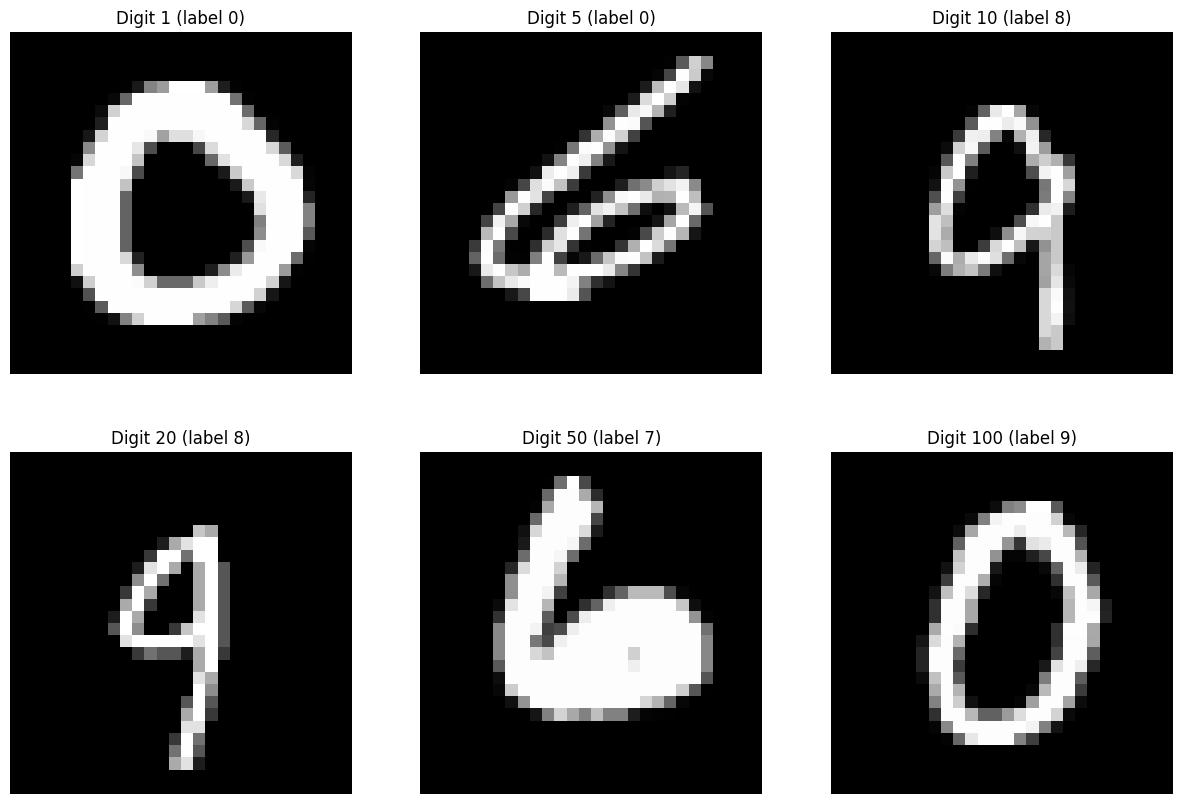

In [ ]:
import matplotlib.pyplot as plt

def visualize_image(index, X):
  try:
    img = X_filtered.iloc[index].values.reshape(28, 28)
    return img
  except IndexError:
    print(f"Index {index} is out of range. Please provide a valid index.")
  except Exception as e:
    print(f"An error occurred: {e}")

indices = [1, 5, 10, 20, 50, 100]
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, index in enumerate(indices):
    axs[i].imshow(visualize_image(index, X_filtered), cmap='gray')
    axs[i].set_title(f"Digit {index} (label {y[index]})")
    axs[i].axis('off')


In [ ]:
from sklearn.decomposition import PCA

k = 2
pca = PCA(n_components=k, random_state=42)
pca.fit(X_train)                # "learn" the PCA on X_train
Z_train = pca.transform(X_train) # project X_train to k=2 dimension

print("Z_train shape:", Z_train.shape)  # (N_train, 2)


Z_train shape: (9965, 2)


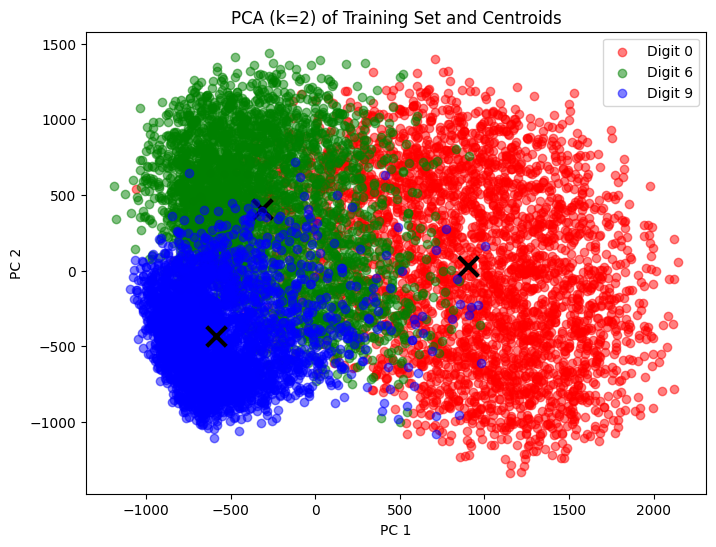

In [ ]:
centroids = {}
for digit in [0, 6, 9]:
    # Points in the projected space belonging to this digit
    cluster_points = Z_train[y_train == digit]
    # Mean along each dimension of the cluster
    centroid = np.mean(cluster_points, axis=0)
    centroids[digit] = centroid

# Let's plot the centroids on top of the scatter plot
plt.figure(figsize=(8, 6))
colors = {0: 'r', 6: 'g', 9: 'b'}
for digit in [0, 6, 9]:
    cluster_points = Z_train[y_train == digit]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                alpha=0.5, label=f"Digit {digit}",
                c=colors[digit])
    # Plot centroid
    plt.scatter(centroids[digit][0], centroids[digit][1],
                c='k', marker='x', s=200, linewidths=3)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.title("PCA (k=2) of Training Set and Centroids")
plt.show()


In [ ]:
from numpy.linalg import norm

avg_distances_train = {}
for digit in [0, 6, 9]:
    cluster_points = Z_train[y_train == digit]
    centroid = centroids[digit]
    # Euclidean distance from each point to centroid
    dists = np.linalg.norm(cluster_points - centroid, axis=1)
    avg_distances_train[digit] = np.mean(dists)

for digit in [0, 6, 9]:
    print(f"Average distance in train set for digit {digit}: {avg_distances_train[digit]:.4f}")


Average distance in train set for digit 0: 735.1214
Average distance in train set for digit 6: 531.0754
Average distance in train set for digit 9: 359.7055


In [ ]:
Z_test = pca.transform(X_test)

avg_distances_test = {}
for digit in [0, 6, 9]:
    cluster_points_test = Z_test[y_test == digit]
    # We use the centroid computed from the training set
    centroid_train = centroids[digit]
    dists_test = np.linalg.norm(cluster_points_test - centroid_train, axis=1)
    avg_distances_test[digit] = np.mean(dists_test)

for digit in [0, 6, 9]:
    print(f"Average distance in test set for digit {digit}: {avg_distances_test[digit]:.4f}")


Average distance in test set for digit 0: 713.7330
Average distance in test set for digit 6: 539.4548
Average distance in test set for digit 9: 366.1902


In [ ]:
def nearest_centroid_classifier(z, centroids):
    """
    x : a single observation (784-dimensional row)
    centroids : dictionary {digit: centroid_in_Z}
    returns the digit whose centroid is closest in Euclidean distance
    """
    min_dist = float('inf')
    best_digit = None
    for digit, centroid in centroids.items():
        dist = norm(z - centroid)
        if dist < min_dist:
            min_dist = dist
            best_digit = digit
    return best_digit

# Compute misclassification rate on the test set
preds = []
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Z_test = pca.transform(X_test)

for i in range(len(Z_test)):
    z = Z_test[i]

    pred_label = nearest_centroid_classifier(z, centroids)
    preds.append(pred_label)

preds = np.array(preds)
accuracy = np.mean(preds == y_test)
misclassification_rate = 1 - accuracy
print(f"Nearest-centroid classification accuracy: {accuracy:.4f}")
print(f"Misclassification rate: {misclassification_rate:.4f}")


Nearest-centroid classification accuracy: 0.8451
Misclassification rate: 0.1549


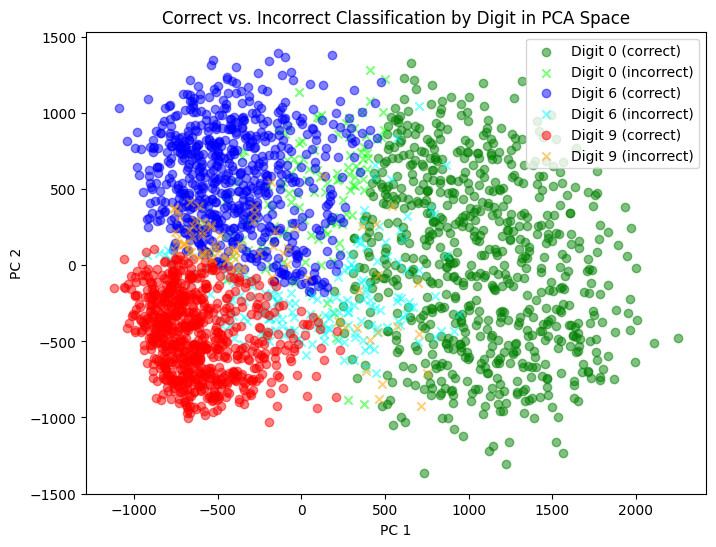

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# If you want to define custom colors for each digit:
# You can define them in a dictionary: digit -> (color_correct, color_incorrect)
color_map = {
    0:  ('green', 'lime'),    # or ('#2ca02c', '#98df8a') if you prefer different shades
    6:  ('blue', 'cyan'),
    9:  ('red', 'orange')
}

plt.figure(figsize=(8, 6))

# Plot each digit in its own color
for digit in  [0, 6, 9]:
    # Correct classification for this digit
    correct_mask_digit = (y_test == digit) & (preds == digit)
    # Incorrect classification for this digit
    incorrect_mask_digit = (y_test == digit) & (preds != digit)

    # Plot the correct points
    plt.scatter(
        Z_test[correct_mask_digit, 0],
        Z_test[correct_mask_digit, 1],
        color=color_map[digit][0],
        alpha=0.5,
        label=f"Digit {digit} (correct)"
    )

    # Plot the incorrect points
    plt.scatter(
        Z_test[incorrect_mask_digit, 0],
        Z_test[incorrect_mask_digit, 1],
        color=color_map[digit][1],
        alpha=0.5,
        marker='x',
        label=f"Digit {digit} (incorrect)"
    )

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Correct vs. Incorrect Classification by Digit in PCA Space")
plt.legend()
plt.show()


In [ ]:
y = dataset['label']
X = dataset.drop('label', axis=1)

# Assuming X is already defined as a NumPy array (if not, convert it using X = np.array(X))
X_filtered = X[(y == 1) | (y == 2) | (y == 3) | (y==4)]
y_filtered = y[(y == 1) | (y == 2) | (y == 3) | (y==4)]

print("Shape of X_filtered:", X_filtered.shape)
print("Shape of y_filtered:", y_filtered.shape)

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

for k in [2, 5, 10, 20, 50]:
    pca = PCA(n_components=k, random_state=42)
    pca.fit(X_train)
    Z_train = pca.transform(X_train)

    # Compute centroids in the k-dimensional space
    centroids = {}
    for digit in [1, 2, 3, 4]:
        cluster_points = Z_train[y_train == digit]
        centroids[digit] = np.mean(cluster_points, axis=0)

    # Evaluate classification on the test set
    Z_test = pca.transform(X_test)
    preds = []
    for i in range(len(Z_test)):
        z = Z_test[i]
        # Nearest centroid logic:
        min_dist = float('inf')
        best_digit = None
        for digit, centroid in centroids.items():
            dist = norm(z - centroid)
            if dist < min_dist:
                min_dist = dist
                best_digit = digit
        preds.append(best_digit)
    preds = np.array(preds)
    acc = np.mean(preds == y_test)
    print(f"k = {k}, accuracy = {acc:.4f}")


Shape of X_filtered: (17284, 784)
Shape of y_filtered: (17284,)
k = 2, accuracy = 0.7755
k = 5, accuracy = 0.8967
k = 10, accuracy = 0.9060
k = 20, accuracy = 0.9069
k = 50, accuracy = 0.9100


We observe that by increasing dimention we can have better accuracy becuase we will lost less data because of prjection on lower dimention

Compare to the SVD classification we have lower accuracy bacuase we don't have this information loss in SVD and we are doing the classification process on original dimention ( 784 )